In [1]:
import os 
import cv2
import numpy as np
from PIL import Image
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.activations import relu
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob as gb
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
import re
from keras.preprocessing.image import img_to_array
from tqdm import tqdm
from PIL import Image

In [2]:
x_train_path = '/kaggle/input/landscape-image-colorization/landscape Images/gray'
y_train_path = '/kaggle/input/landscape-image-colorization/landscape Images/color'


In [3]:
gray_img=[]
color_img=[]
for img in os.listdir(x_train_path):
    image_path = os.path.join(x_train_path,img)
    g=Image.open(image_path)
    new_size = (224,224)
    resized_img = g.resize(new_size)
    gray_img.append(resized_img)
for img in os.listdir(y_train_path):
    image_path = os.path.join(y_train_path,img)
    g=Image.open(image_path)
    new_size = (224, 224)
    resized_img = g.resize(new_size)
    color_img.append(resized_img)
    

In [4]:
gray_img=np.array(gray_img)
color_img=np.array(color_img)
gray_img=np.expand_dims(gray_img,axis=-1)
gray_img=gray_img/255
color_img=color_img/255


In [5]:
train_gray_img=gray_img[:6000]
test_gray_img=gray_img[6000:]
train_color_img=color_img[:6000]
test_color_img=color_img[6000:]

In [6]:
print(train_gray_img.shape)
print(test_gray_img.shape)
print(train_color_img.shape)
print(test_color_img.shape)

(6000, 224, 224, 1)
(1129, 224, 224, 1)
(6000, 224, 224, 3)
(1129, 224, 224, 3)


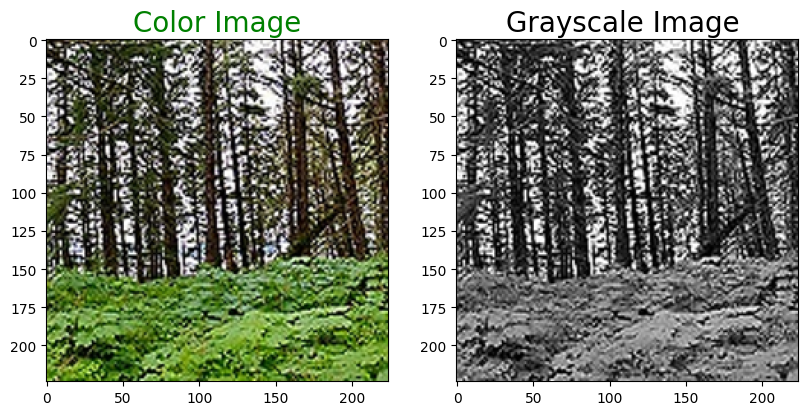

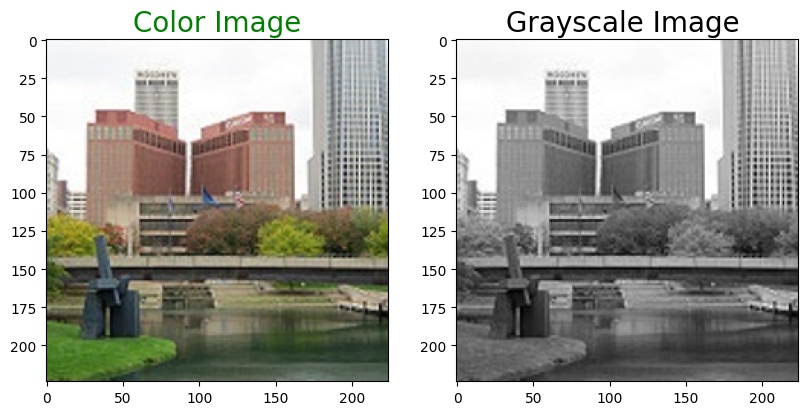

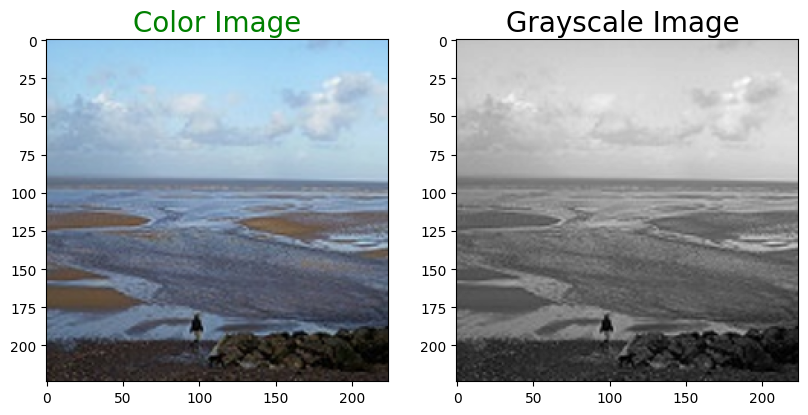

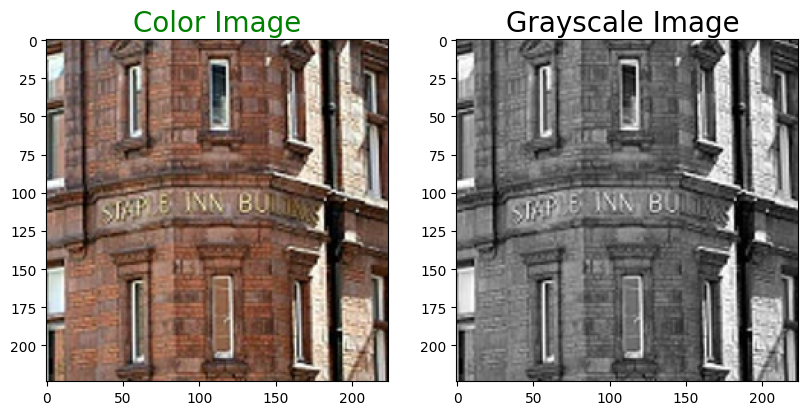

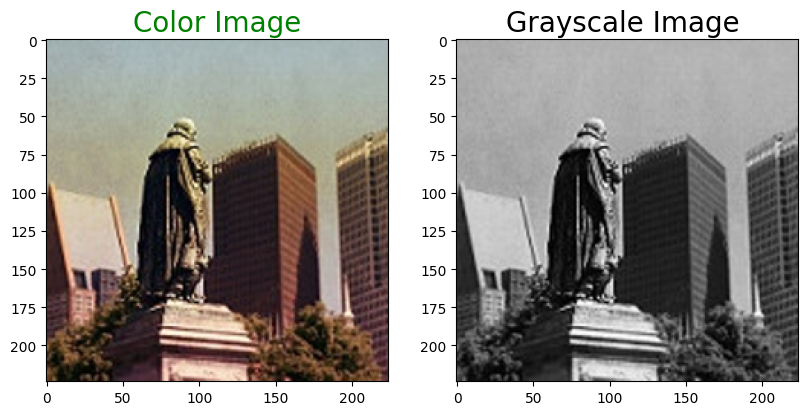

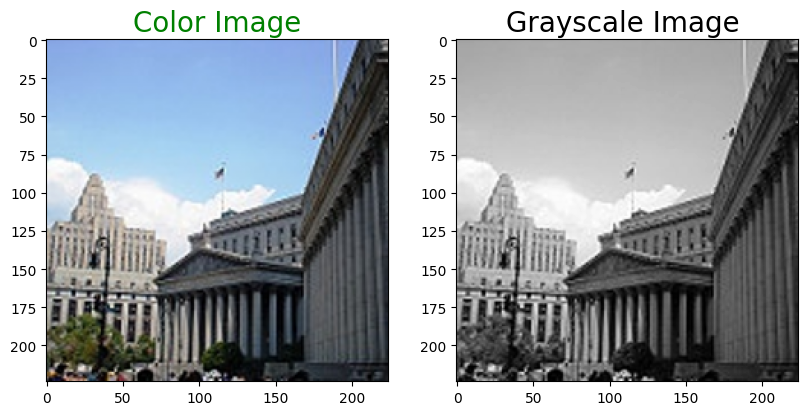

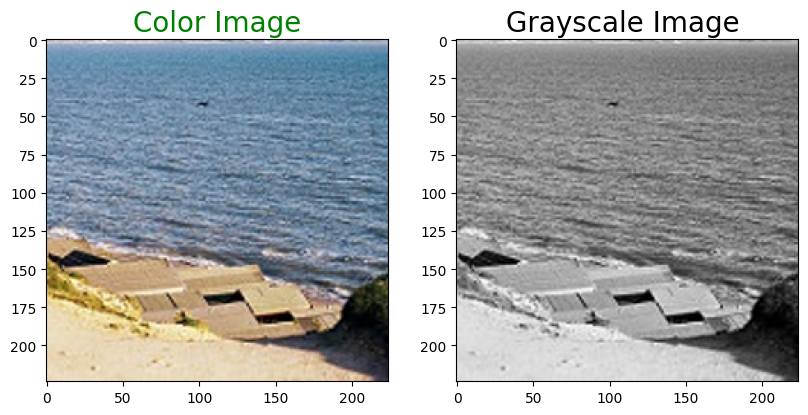

In [15]:
def plot_images(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale,cmap='gray')
   
    plt.show()
for i in range(3,10):
     plot_images(train_color_img[i],train_gray_img[i])

In [8]:
def u_net(h=(224,224,1)):
  gg=layers.Input(shape=h)
  x= gg
  conv =[]
  f=64

  #down_sampling
  for i in range (4):
    x= layers.Conv2D(f,3,activation='relu',padding='same')(x)
    x= layers.Conv2D(f,3,activation='relu',padding='same')(x)
    conv.append(x)
    x= layers.MaxPooling2D()(x)
    f*=2

  
  #bottle-neck
  x= layers.Conv2D(f,3,activation='relu',padding='same')(x)
  x= layers.Conv2D(f,3,activation='relu',padding='same')(x)


  ff=512
  j= len(conv)-1
  #up-sampling
  for i in range(4):
    x=layers.Conv2DTranspose(ff,2,strides=(2,2),padding='same')(x)
    x=layers.Concatenate(axis=3)([x,conv[j]])
    x= layers.Conv2D(ff,3,activation='relu',padding='same')(x)
    x= layers.Conv2D(ff,3,activation='relu',padding='same')(x)
    ff//=2
    j-=1


  output = layers.Conv2D(3,1,padding='same')(x)
  model = models.Model(inputs=gg,outputs=output)
  return model

In [9]:
# from keras import layers
# def down(filters , kernel_size, apply_batch_normalization = True):
#     downsample = tf.keras.models.Sequential()
#     downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
#     if apply_batch_normalization:
#         downsample.add(layers.BatchNormalization())
#     downsample.add(keras.layers.LeakyReLU())
#     return downsample


# def up(filters, kernel_size, dropout = False):
#     upsample = tf.keras.models.Sequential()
#     upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
#     if dropout:
#         upsample.dropout(0.2)
#     upsample.add(keras.layers.LeakyReLU())
#     return upsample
# def model():
#     inputs = layers.Input(shape= [160,160,3])
#     d1 = down(128,(3,3),False)(inputs)
#     d2 = down(128,(3,3),False)(d1)
#     d3 = down(256,(3,3),True)(d2)
#     d4 = down(512,(3,3),True)(d3)
    
#     d5 = down(512,(3,3),True)(d4)
#     #upsampling
#     u1 = up(512,(3,3),False)(d5)
#     u1 = layers.concatenate([u1,d4])
#     u2 = up(256,(3,3),False)(u1)
#     u2 = layers.concatenate([u2,d3])
#     u3 = up(128,(3,3),False)(u2)
#     u3 = layers.concatenate([u3,d2])
#     u4 = up(128,(3,3),False)(u3)
#     u4 = layers.concatenate([u4,d1])
#     u5 = up(3,(3,3),False)(u4)
#     u5 = layers.concatenate([u5,inputs])
#     output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
#     return tf.keras.Model(inputs=inputs, outputs=output)
# model = model()
# model.compile(optimizer = 'adam', loss = 'mean_absolute_error',metrics = ['acc'])
# model.fit(train_gray_img,train_color_img,batch_size=32,epochs=2)

In [10]:
model = u_net()
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mse'])
model.fit(train_gray_img,train_color_img,batch_size=32,epochs=2)

Epoch 1/2


I0000 00:00:1728592907.078434    1315 service.cc:145] XLA service 0x7d6af00222f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728592907.078504    1315 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1728592907.078511    1315 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-10-10 20:42:15.807154: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=2} for conv (f32[32,128,112,112]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,256,112,112]{3,2,1,0}, f32[128,256,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-10-10 20:42:15.

187/188 ━━━━━━━━━━━━━━━━━━━━ 0s 993ms/step - loss: 0.3804 - mse: 0.3804

2024-10-10 20:46:59.537266: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{k11=1} for conv (f32[16,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-10-10 20:46:59.784713: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.247638712s
Trying algorithm eng4{k11=1} for conv (f32[16,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"c

188/188 ━━━━━━━━━━━━━━━━━━━━ 358s 1s/step - loss: 0.3777 - mse: 0.3777
Epoch 2/2
188/188 ━━━━━━━━━━━━━━━━━━━━ 186s 990ms/step - loss: 0.0081 - mse: 0.0081


In [ ]:
# model.fit(train_gray_img,train_color_img,batch_size=32,epochs=5)

In [12]:
predicted=model.predict(test_gray_img)


36/36 ━━━━━━━━━━━━━━━━━━━━ 27s 749ms/step


In [17]:
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image', color = 'green', fontsize = 20)
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ', color = 'black', fontsize = 20)
    plt.imshow(grayscale,cmap='gray')
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

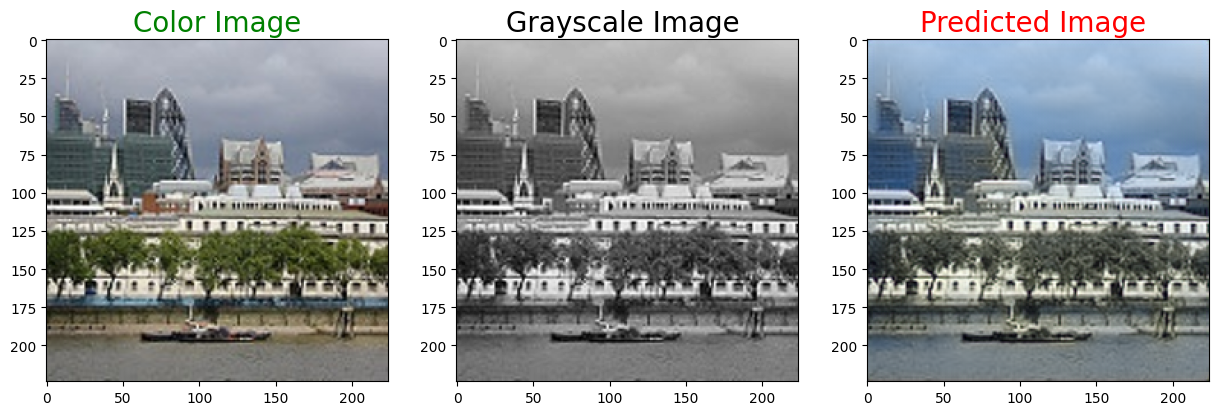

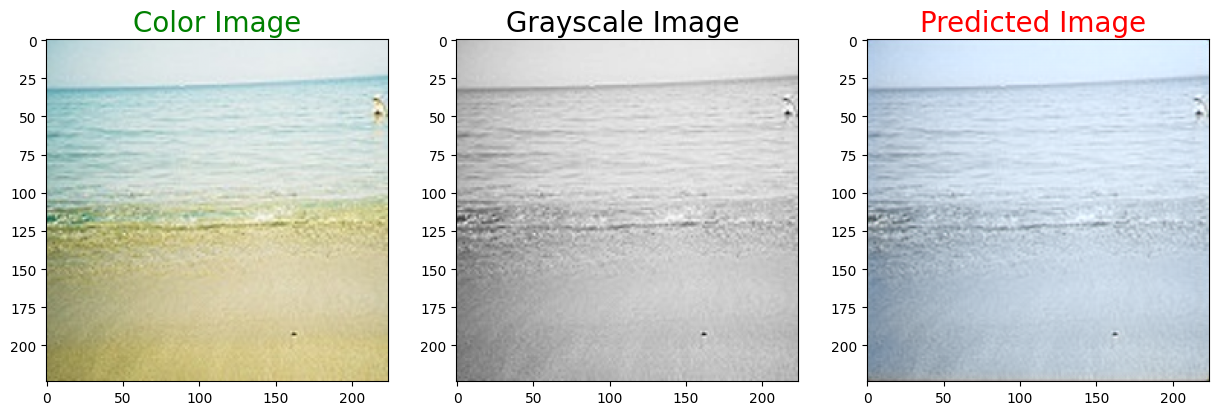

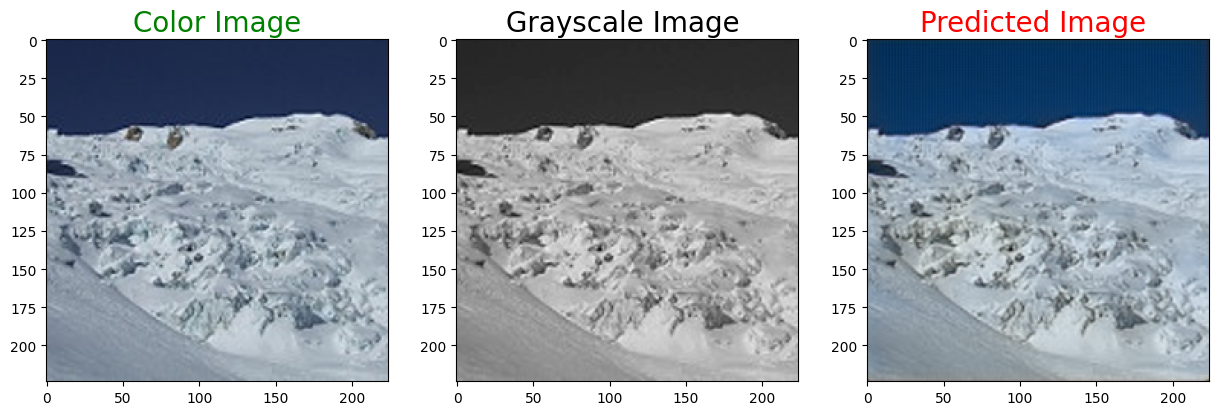

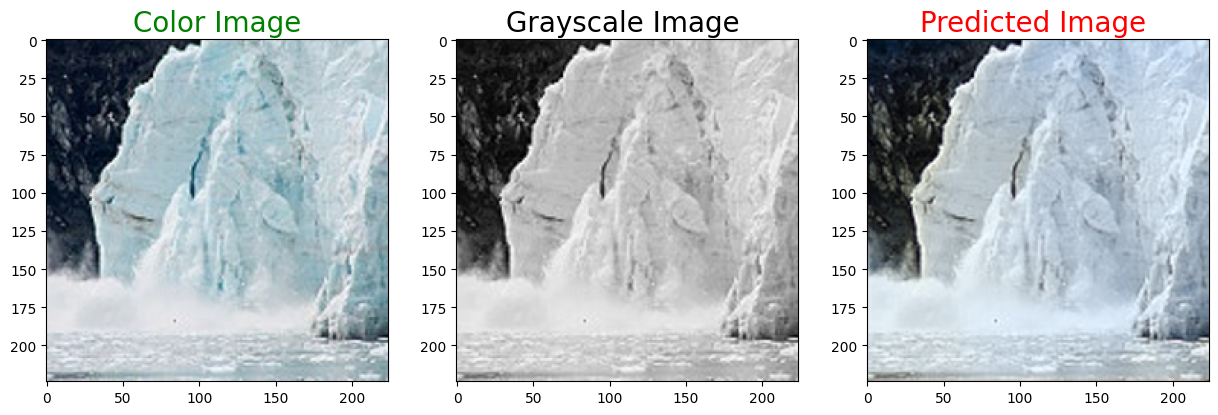

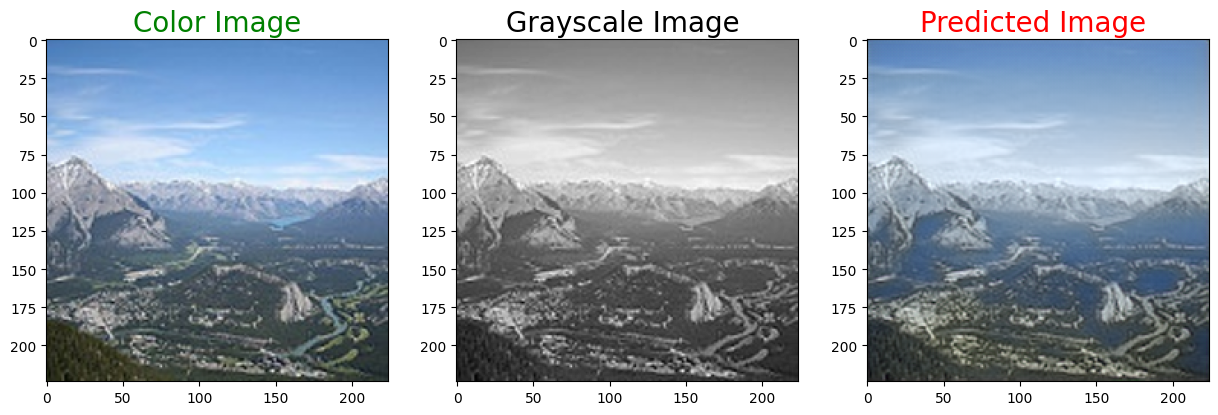

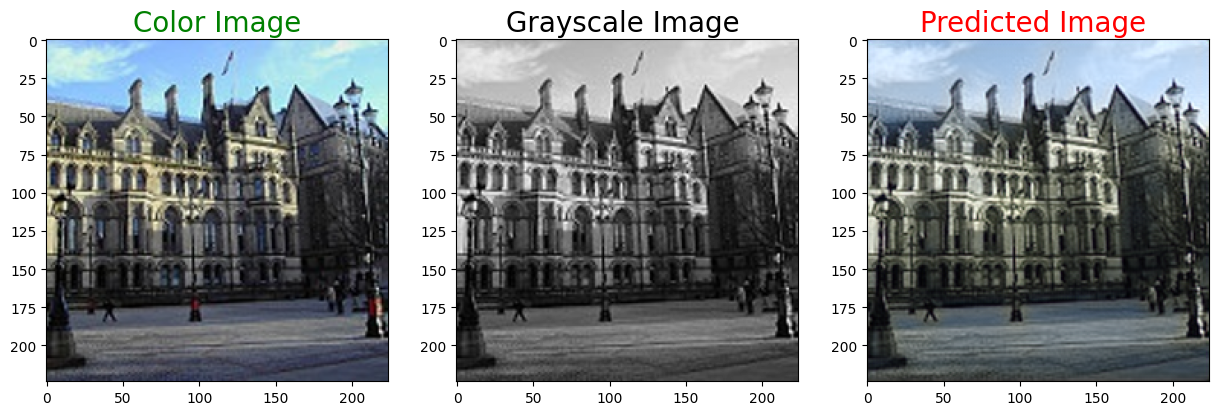

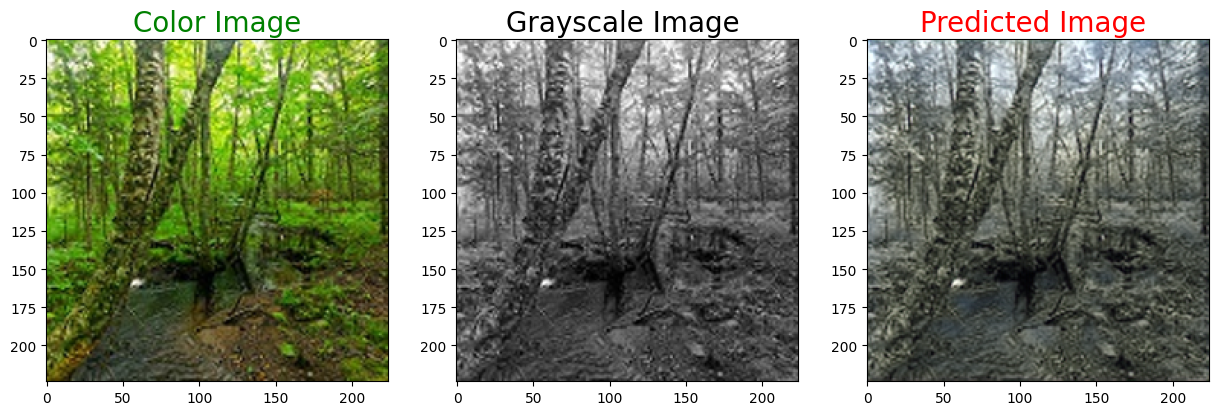

In [19]:
for i in range(3,10):
     plot_images(test_color_img[i],test_gray_img[i],predicted[i])